In [1]:
import findspark
findspark.init()

import time as t
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.streaming import StreamingContext
from pyspark.sql import functions as F
from pyspark.sql.types import *
from datetime import datetime, timedelta, date
import sys
from lib import sparkStructuredStreaming
import os
%matplotlib inline
from matplotlib import pyplot as plt
from pyspark.sql.window import Window
import math as m
import pandas as pd

### Set-up to stream from Kafka topic + read and write from/to Elasticsearch

In [2]:
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages org.apache.spark:spark-sql-kafka-0-10_2.11:2.4.5,org.elasticsearch:elasticsearch-spark-20_2.11:7.6.2 pyspark-shell'

In [3]:
#"127.0.0.1:9092" (local) //"10.0.0.8:9092" (BACC)
bootstrap = "127.0.0.1:9092"
hdfs_path = "hdfs://0.0.0.0:19000"

In [4]:
spark = SparkSession \
            .builder \
            .appName("KafkaIEXStructuredStreamingRobovisor") \
            .master("local[*]") \
            .getOrCreate()

sqlContext = SQLContext(spark)

## 1. Backtesting

In [6]:
b = sparkStructuredStreaming.backtest()
hdfs_path = "hdfs://0.0.0.0:19000"
start = date(2020,6,3)
end = date(2020,6,3)

#strategy looks at last 10,120,500... minutes to calculate average
strategy_momentum = ["momentum",60,120]

# granularity of historical data
interval_momentum="1m"

#start capital
startCap = 10000.0
startCap_market = startCap

# regulatory trading fee
commission = 0.006

# risk free market return, assumed here 0.1% but is not really clear
risk_free = 0.001

# parameters to find stock symbols
n_stock = [2]
period = [2]

best_of = 5
    
b.full_backtest(startCap, startCap_market, commission, risk_free, strategy_momentum, interval_momentum, start, end, period, n_stock, hdfs_path, sqlContext, best_of, "static_no_best")

[*********************100%***********************]  456 of 456 completed
[*********************100%***********************]  456 of 456 completed
[*********************100%***********************]  1 of 1 completed


In [15]:
per_comp = sqlContext.read.format('parquet').load(hdfs_path+"/backtest/performance_full/20200507").toPandas()
depot_comp = sqlContext.read.format('parquet').load(hdfs_path+"/backtest/depot_full/20200507").toPandas()
perf_sim = sqlContext.read.format('parquet').load(hdfs_path+"/backtest/performance_best").toPandas()
depot_sim = sqlContext.read.format('parquet').load(hdfs_path+"/backtest/depot_best").toPandas()

## Compare performance of different strategies on May 7th

In [28]:
df_perf = per_comp[["DepotId","Value","Alpha","Beta","Start-Capital","Profit","Trades","Performance_Strategy","Performance_S&P500"]].sort_values(by=['Performance_Strategy'],ascending=False)
df_perf

,DepotId,Value,Alpha,Beta,Start-Capital,Profit,Trades,Performance_Strategy,Performance_S&P500
27,62,10656.87,6.75,0.64,10000.0,656.87,61,6.57,-0.29
48,63,10520.94,5.40,0.65,10000.0,520.94,27,5.21,-0.29
91,5,10178.96,2.09,1.03,10000.0,178.96,3,1.79,-0.29
6,61,10115.13,1.31,0.56,10000.0,115.13,222,1.15,-0.29
32,92,10103.78,1.22,0.64,10000.0,103.78,54,1.04,-0.29
...,...,...,...,...,...,...,...,...,...
8,11,9322.48,-6.51,0.90,10000.0,-677.52,1383,-6.78,-0.29
4,71,9304.73,-6.67,0.97,10000.0,-695.27,1566,-6.95,-0.29
14,26,9267.40,-7.13,0.67,10000.0,-732.60,944,-7.33,-0.29
13,86,9203.21,-7.73,0.81,10000.0,-796.79,1334,-7.97,-0.29


In [38]:
merged = df_perf.merge(depot_comp, how="left", on="DepotId")[["DepotId","Strategy","ISIN","Share"]]
merged

,DepotId,Strategy,ISIN,Share
0,62,momentum60,"[HOLX, FLIR]","[0.67, 0.33]"
1,63,momentum120,"[HOLX, FLIR]","[0.67, 0.33]"
2,5,Buy and Hold,"[FLIR, ATVI]","[0.67, 0.33]"
3,61,momentum10,"[HOLX, FLIR]","[0.67, 0.33]"
4,92,momentum60,"[HOLX, ATVI]","[0.67, 0.33]"
...,...,...,...,...
100,11,momentum10,"[FLIR, ATVI, KLAC, DVA, BWA, WY, FFIV, AOS, AL...","[0.18, 0.16, 0.15, 0.13, 0.11, 0.09, 0.07, 0.0..."
101,71,momentum10,"[HOLX, FLIR, DVN, FFIV, ALGN, PKI, PYPL, EBAY,...","[0.18, 0.16, 0.15, 0.13, 0.11, 0.09, 0.07, 0.0..."
102,26,momentum10,"[ATVI, PCG, CLX, IPGP, VRTX, REGN, HOLX, CTXS,...","[0.18, 0.16, 0.15, 0.13, 0.11, 0.09, 0.07, 0.0..."
103,86,momentum10,"[HOLX, PCG, EBAY, IPGP, PYPL, EFX, LOW, PKI, A...","[0.18, 0.16, 0.15, 0.13, 0.11, 0.09, 0.07, 0.0..."


## Simulate Trading from May 11th - June 3rd by chossing the strategy which worked best the day before

In [44]:
perf_sim[["DepotId","Value","Alpha","Beta","Start-Capital","Profit","Start-Date","Performance_Strategy","Performance_S&P500"]].sort_values(by=['Start-Date'],ascending=True)

,DepotId,Value,Alpha,Beta,Start-Capital,Profit,Start-Date,Performance_Strategy,Performance_S&P500
5,1,10160.58,-0.21,1.80,10000.00,160.58,2020-05-11,1.61,1.01
3,2,10075.65,2.40,1.37,10160.58,-84.93,2020-05-12,-0.84,-2.36
8,3,10049.17,-0.10,0.11,10075.65,-26.48,2020-05-13,-0.26,-1.50
11,4,10029.27,-0.62,0.22,10049.17,-19.90,2020-05-14,-0.20,1.89
4,5,10165.37,0.06,1.00,10029.27,136.10,2020-05-15,1.36,1.30
0,6,10409.53,0.96,2.19,10165.37,244.16,2020-05-18,2.40,0.66
7,7,10130.08,-1.62,1.74,10409.53,-279.45,2020-05-19,-2.68,-0.61
1,8,9849.66,-2.96,0.55,10130.08,-280.42,2020-05-20,-2.77,0.34
14,9,10502.50,NaN,NaN,9849.66,652.84,2020-05-21,6.63,-0.72
15,10,10934.73,NaN,NaN,10502.50,432.23,2020-05-22,4.12,0.28


In [46]:
depot_sim[["DepotId","Strategy","ISIN","Share"]].sort_values(by=['DepotId'],ascending=True)

,DepotId,Strategy,ISIN,Share
10,1,momentum120,"[LNC, BHF]","[0.5, 0.5]"
9,2,momentum120,"[NKTR, HP]","[0.5, 0.5]"
8,3,momentum120,"[ABBV, OKE]","[0.5, 0.5]"
11,4,momentum120,"[GIS, MKC]","[0.5, 0.5]"
12,5,momentum60,"[CTAS, BLK]","[0.5, 0.5]"
2,6,Buy and Hold,"[CTAS, FLR]","[0.5, 0.5]"
1,7,Buy and Hold,"[RCL, EXPE]","[0.5, 0.5]"
16,8,momentum60,"[RRC, UAL]","[0.5, 0.5]"
5,9,Buy and Hold,"[ARNC, RE]","[0.5, 0.5]"
14,10,momentum60,"[ARNC, LB]","[0.5, 0.5]"


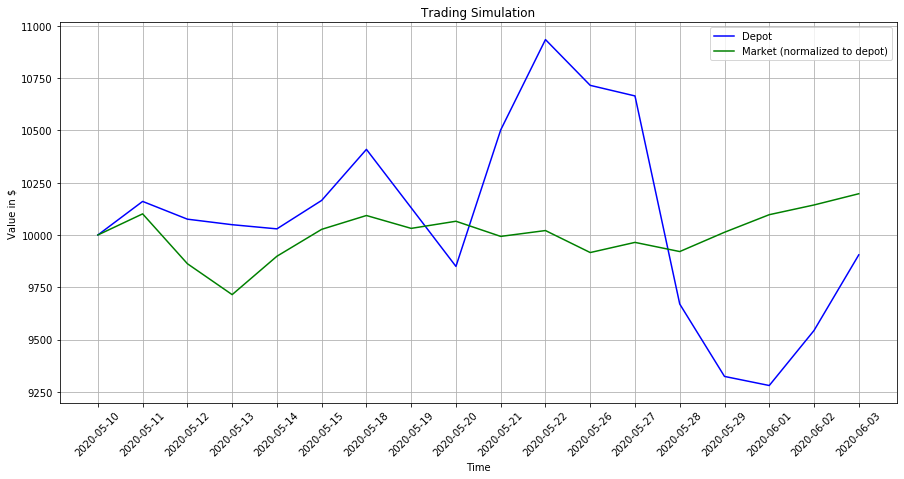

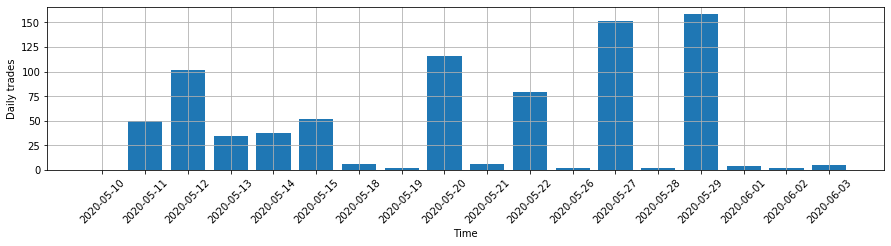

In [42]:
performance_best = sqlContext.read.format('parquet').load(hdfs_path+"/backtest/performance_best").orderBy("DepotId")
performance_best_col = performance_best.collect()
n = len(performance_best_col)
start_vals = performance_best_col[0]

date_list = [(start_vals['Start-Date']-timedelta(days=1)).strftime("%Y-%m-%d")]
trades = [0, 0]
performance = [start_vals['Start-Capital']]
performance_snp = [start_vals['Start-Capital_S&P500']]

for row in performance_best_col:
    date_list.append(row['Start-Date'].strftime("%Y-%m-%d"))
    performance.append(row["Value"])
    performance_snp.append(row["Value_S&P500"]) 
    trades.append(row["Trades"])

trades_daily = [trades[i]-trades[i-1] for i in range(1,len(trades))] 
plt.figure(figsize=[15,7])

plt.plot(date_list,performance,'b',label="Depot")
plt.plot(date_list,performance_snp,'g', label="Market (normalized to depot)")
plt.grid()
plt.xlabel("Time")
plt.ylabel("Value in $")
plt.legend()
plt.title("Trading Simulation")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=[15,3])
plt.grid()
plt.xlabel("Time")
plt.ylabel("Daily trades")
plt.xticks(rotation=45)
plt.bar(date_list, trades_daily)
plt.show()

## 2. Trading Simulation / Performance Evaluation with realtime Streams (Spark Streaming)

### Stream real time quotes from Kafka topic

In [5]:
r = sparkStructuredStreaming.realtime()
day = date(2020,6,4)
sandbox = False
commission = 0.006
startCap = 10000.0

r.realtime(startCap, day, sandbox, commission, sqlContext)

[*********************100%***********************]  456 of 456 completed


C:\Users\LEGLES\anaconda\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


{'value': 9997.955740000001, 'date': '2020-06-03T15:03:18', 'depotid': '20200603', 'trades': 2}
no new data
no new data
no new data
no new data
no new data
no new data
no new data
no new data
no new data
no new data
no new data
no new data
no new data
no new data
no new data
no new data
no new data
no new data
no new data
no new data
no new data
no new data
no new data
{'value': 9994.59574, 'date': '2020-06-03T15:04:02', 'depotid': '20200603', 'trades': 2}
no new data
no new data
no new data
no new data
no new data
no new data
no new data
no new data
no new data
no new data
no new data
no new data
no new data
no new data
no new data
no new data
no new data
no new data
no new data
no new data
no new data
no new data
no new data
no new data
no new data
no new data
no new data
no new data
no new data
{'value': 9999.55574, 'date': '2020-06-03T15:04:55', 'depotid': '20200603', 'trades': 2}
no new data
no new data
no new data
no new data
no new data
no new data
no new data
no new data
no new

Exception ignored in: <function JavaObject.__init__.<locals>.<lambda> at 0x00000231511C53A8>
Traceback (most recent call last):
  File "c:\spark\python\lib\py4j-0.10.7-src.zip\py4j\java_gateway.py", line 1293, in <lambda>
  File "c:\spark\python\lib\py4j-0.10.7-src.zip\py4j\java_gateway.py", line 625, in _garbage_collect_object
  File "c:\spark\python\lib\py4j-0.10.7-src.zip\py4j\java_gateway.py", line 920, in garbage_collect_object
  File "c:\spark\python\lib\py4j-0.10.7-src.zip\py4j\java_gateway.py", line 985, in send_command
  File "c:\spark\python\lib\py4j-0.10.7-src.zip\py4j\java_gateway.py", line 1152, in send_command
  File "C:\Users\LEGLES\anaconda\lib\socket.py", line 589, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt: 


no new data
no new data
no new data
no new data
no new data
no new data
no new data
no new data
no new data
no new data
no new data
no new data
no new data
no new data
no new data
no new data
no new data
no new data
no new data
no new data
no new data
no new data
no new data
no new data
no new data
no new data
no new data
no new data
no new data
no new data
no new data
no new data
no new data
no new data
no new data
no new data
no new data
no new data
no new data
no new data
no new data
no new data
no new data
no new data
no new data
no new data
no new data
no new data
no new data
no new data
no new data
no new data
no new data
no new data
no new data
no new data
no new data
no new data
no new data
no new data
no new data
no new data
no new data
no new data
no new data
no new data
no new data
no new data
no new data
no new data
no new data
no new data
no new data


KeyboardInterrupt: 